### Importing Important Modules 

In [1]:
#Enabling interactive secession for the notebook and save in very 20 second.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%autosave 20

Autosaving every 20 seconds


In [2]:
from __future__ import print_function
import torch                                #Importing Torch module as ml framework desined for reserchers and developer.
import torch.nn as nn                       #NN module have classes and modules to implement and train the neural network.
import torch.nn.functional as F             #Functional provides module like activations,losses etc
import torch.optim as optim                 #Importing optimizer moduke from torch
from torchvision import datasets, transforms#Importing Torch vision for datasets and data transforms.

/home/jd/miniconda3/envs/eva/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
#importing a module created by me to calculate receptive field.Having copule of bugs but works fine.
from  rf_calc import receptive_field

In [4]:
torch.__version__ #checking Troch version

'1.13.0'

In [5]:
#Checking for torch GPU support
print(f"Is cuda GPU avalable: {torch.cuda.is_available()}")

Is cuda GPU avalable: True


In [6]:
use_cuda = torch.cuda.is_available() #chjecking if cuda is available or not
device = torch.device("cuda" if use_cuda else "cpu") #if gpu is available then device = cuda else cpu
torch.manual_seed(1)
batch_size = 128
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [7]:
### Defining train loader and test loader 

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,  #downloading the data at /data folder,its for trainning
                    transform=transforms.Compose([       #data transformation includes converting to tensor and normalizing with the mean and std of the dataset
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

### Trainning Function

from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()   #model set to trainning
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar): # Iterating through data and target
        data, target = data.to(device), target.to(device)  #pushing data and target to gpu
        optimizer.zero_grad() # making all the gradients to zero
        output,x1,x2,x3,x4,x5 = model(data) # predicting op
        type(output)
        loss = F.nll_loss(output, target) # calculating loss
        loss.backward()  # This is backpropagation in action.
        optimizer.step() # Updating old weights with new 
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')

### Testing Function

def test(model, device, test_loader):
    model.eval()  #Model set to evaluation mode.
    test_loss = 0  
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output,x1,x2,x3,x4,x5 = model(data)   #predicting the test data
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.4f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

###  Model Class defination

In [8]:
class Net(nn.Module):       #created a model class as Net  inhereate properties from nn.Modules
    def __init__(self,x_times = 1):     #defining Init function.
        super(Net, self).__init__()
        x_times = x_times
        self.conv1 = nn.Conv2d(1,8, 3, padding=1)    #input:28*28  OUtput:28*28 RF:3*3   (RF Considering MaxPooling doubles the RF for now)
        self.conv2 = nn.Conv2d(8, 8, 3, padding=1)   #input:28*28  OUtput:28*28 RF:5*5
        self.pool1 = nn.MaxPool2d(2, 2)                #input:28*28  OUtput:14*14 RF:10*10
        self.conv3 = nn.Conv2d(8, 16, 3, padding=1)  #input:14*14  OUtput:14*14 RF:12*12
        self.conv4 = nn.Conv2d(16, 16, 3, padding=1) #input:14*14  OUtput:14*14 RF:14*14
        self.pool2 = nn.MaxPool2d(2, 2)                #input:14*14  OUtput:7*7 RF:28*28
        self.conv5 = nn.Conv2d(16, 32, 3)            #input:7*7    OUtput:5*5 RF:30*30
        self.conv6 = nn.Conv2d(32, 64, 3)           #input:5*5    OUtput:3*3 RF:32*32
        self.conv7 = nn.Conv2d(64, 10, 3)            #input:3*3    OUtput:1*1 RF:34*34
        
    def forward(self, x):  #forward functions
        x1 = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x))))) #maxpool--> relu-->conv2-->relu-->conv1
        x2 = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x1))))) #maxpool--> relu-->conv4-->relu-->conv3
        x3 = F.relu(self.conv6(F.relu(self.conv5(x2))))             #relu-->conv6-->relu-->conv5
        x4 = self.conv7(x3)                                         #conv7
        x5 = x4.view(-1, 10)                                        #Changing dimention of data.
        return F.log_softmax(x5,-1),x1,x2,x3,x4,x5                           #Final log softmax layer 

### Base model 

In [9]:
from torchsummary import summary   #importing torchsummary.
model = Net(x_times = 1).to(device) #creating model and sending it to "CPU/CUDA"
summary(model, input_size=(1, 28, 28))  #Printing the model summary details 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2            [-1, 8, 28, 28]             584
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,168
            Conv2d-5           [-1, 16, 14, 14]           2,320
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 5, 5]           4,640
            Conv2d-8             [-1, 64, 3, 3]          18,496
            Conv2d-9             [-1, 10, 1, 1]           5,770
Total params: 33,058
Trainable params: 33,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.13
Estimated Total Size (MB): 0.30
---------------------------------------------

### Let's calculate the Receptive field

In [10]:
rf_df = receptive_field(model_obj=model,input_image=28)

=======================================Reciptive Field Calculator========================================
|    | Kernel_size   | Padding   |   Stride | Input_Img_size   | Output_Img_size   | Receptive_field   |
|---:|:--------------|:----------|---------:|:-----------------|:------------------|:------------------|
|  0 | 3*3           | 1         |        1 | 28*28            | 28*28             | 3*3               |
|  1 | 3*3           | 1         |        1 | 28*28            | 28*28             | 5*5               |
|  2 | 2*2           | NO        |        2 | 28*28            | 14*14             | 6*6               |
|  3 | 3*3           | 1         |        1 | 14*14            | 14*14             | 10*10             |
|  4 | 3*3           | 1         |        1 | 14*14            | 14*14             | 14*14             |
|  5 | 2*2           | NO        |        2 | 14*14            | 7*7               | 16*16             |
|  6 | 3*3           | NO        |        1 | 7*7     

In [11]:
i = 1
print (f"Model Reduced the parameter {i} times the base model")
model = Net(x_times = i).to(device) #creating model and sending it to "CPU/CUDA"
summary(model, input_size=(1, 28, 28))  #Printing the model summary details 
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # setting the optimizer

for epoch in range(1, 2):    # running is for 1 epoch
    train(model, device, train_loader, optimizer, epoch)  # Running the Train Function
    test(model, device, test_loader)    # running the test Function

Model Reduced the parameter 1 times the base model
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
            Conv2d-2            [-1, 8, 28, 28]             584
         MaxPool2d-3            [-1, 8, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           1,168
            Conv2d-5           [-1, 16, 14, 14]           2,320
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7             [-1, 32, 5, 5]           4,640
            Conv2d-8             [-1, 64, 3, 3]          18,496
            Conv2d-9             [-1, 10, 1, 1]           5,770
Total params: 33,058
Trainable params: 33,058
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.13
Estimated Total Size (MB):

loss=0.29519322514533997 batch_id=468: 100%|█████████████████████████████████████████████████████| 469/469 [00:05<00:00, 79.33it/s]



Test set: Average loss: 0.1139, Accuracy: 9640/10000 (96.4000%)



### Let's Take one image and send it to conv and see what's happening 

In [12]:
import matplotlib.pyplot as plt

In [13]:
for batch_idx, (data, target) in enumerate(train_loader): # Iterating through data and target
    data, target = data.to(device), target.to(device)  #pushing data and target to gpu
    break

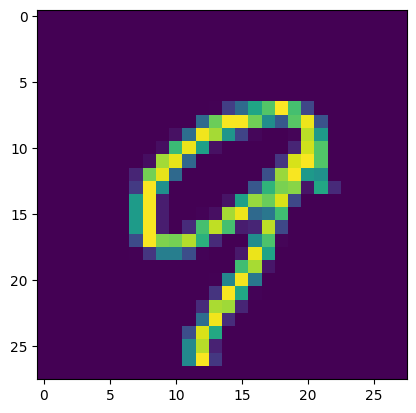

In [14]:
_ = plt.imshow(data[0].reshape(28,28,-1).to('cpu'))

In [15]:
target[0]

tensor(9, device='cuda:0')

In [16]:
output_val,x1,x2,x3,x4,x5 = model(data[0])

In [17]:
output_val

tensor([[ -4.9264, -13.4426,  -8.6280,  -8.7630,  -3.9160,  -9.7017, -10.9797,
          -4.5816,  -7.2728,  -0.0393]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [18]:
x1.shape
x2.shape
x3.shape
x4.shape
x5.shape

torch.Size([8, 14, 14])

torch.Size([16, 7, 7])

torch.Size([64, 3, 3])

torch.Size([10, 1, 1])

torch.Size([1, 10])

In [19]:
x5

tensor([[ 2.4861, -6.0302, -1.2155, -1.3506,  3.4965, -2.2892, -3.5672,  2.8308,
          0.1397,  7.3732]], device='cuda:0', grad_fn=<ViewBackward0>)

### Difference between with relu and without relu

##### With Relu

In [20]:
F.relu(x5)

tensor([[2.4861, 0.0000, 0.0000, 0.0000, 3.4965, 0.0000, 0.0000, 2.8308, 0.1397,
         7.3732]], device='cuda:0', grad_fn=<ReluBackward0>)

In [21]:
F.log_softmax(F.relu(x5),-1)  #Because Relu set the last layer's negative information to zero, the majority of values are identical.

tensor([[-4.9290, -7.4151, -7.4151, -7.4151, -3.9186, -7.4151, -7.4151, -4.5842,
         -7.2754, -0.0419]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [22]:
F.log_softmax(F.relu(x5),-1).squeeze()

tensor([-4.9290, -7.4151, -7.4151, -7.4151, -3.9186, -7.4151, -7.4151, -4.5842,
        -7.2754, -0.0419], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [23]:
#loss
l = F.nll_loss(F.log_softmax(F.relu(x5),-1).squeeze() , target[0])

In [28]:
l

tensor(0.0419, device='cuda:0', grad_fn=<NllLossBackward0>)

AttributeError: 'Net' object has no attribute 'layers'

In [31]:
filters,biases = model.conv7[1].get_parameter()

TypeError: 'Conv2d' object is not subscriptable

##### Without Relu

In [24]:
x5

tensor([[ 2.4861, -6.0302, -1.2155, -1.3506,  3.4965, -2.2892, -3.5672,  2.8308,
          0.1397,  7.3732]], device='cuda:0', grad_fn=<ViewBackward0>)

In [25]:
F.log_softmax(x5,-1)  #Because Relu set the last layer's negative information to zero, the majority of values are identical.

tensor([[ -4.9264, -13.4426,  -8.6280,  -8.7630,  -3.9160,  -9.7017, -10.9797,
          -4.5816,  -7.2728,  -0.0393]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

In [26]:
F.log_softmax(x5,-1).squeeze()

tensor([ -4.9264, -13.4426,  -8.6280,  -8.7630,  -3.9160,  -9.7017, -10.9797,
         -4.5816,  -7.2728,  -0.0393], device='cuda:0',
       grad_fn=<SqueezeBackward0>)

In [27]:
#loss
F.nll_loss(F.log_softmax(x5,-1).squeeze() , target[0])

tensor(0.0393, device='cuda:0', grad_fn=<NllLossBackward0>)

### Let's Visualize some kernels we trainned

In [58]:
import matplotlib.pyplot as plt
from torchvision import utils
import numpy as np

def visTensor(tensor, ch=0, allkernels=False, nrow=8, padding=1): 
    n,c,w,h = tensor.shape

    if allkernels: tensor = tensor.view(n*c, -1, w, h)
    elif c != 3: tensor = tensor[:,ch,:,:].unsqueeze(dim=1)

    rows = np.min((tensor.shape[0] // nrow + 1, 64))    
    grid = utils.make_grid(tensor, nrow=nrow, normalize=True, padding=padding)
    plt.figure( figsize=(nrow,rows) )
    plt.imshow(grid.cpu().numpy().transpose((1, 2, 0)))


def print_layer(filter):
    # layer = ['conv1','conv2','conv3','conv4','conv5','conv6','conv7']
    filter = filter
    visTensor(filter, ch=0, allkernels=False)

    plt.axis('off')
    plt.ioff()
    plt.show()

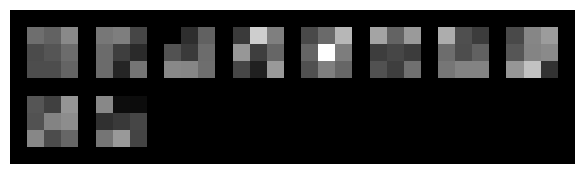

In [59]:
print_layer(model.conv7.weight.detach().clone())

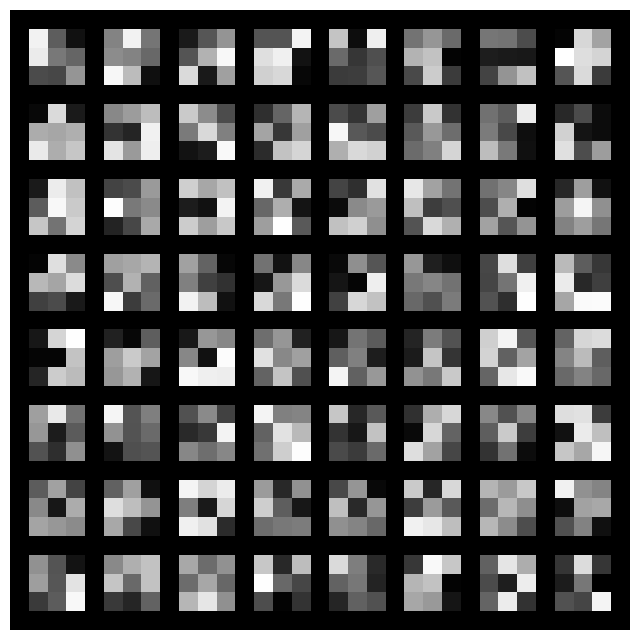

In [60]:
print_layer(model.conv6.weight.detach().clone())

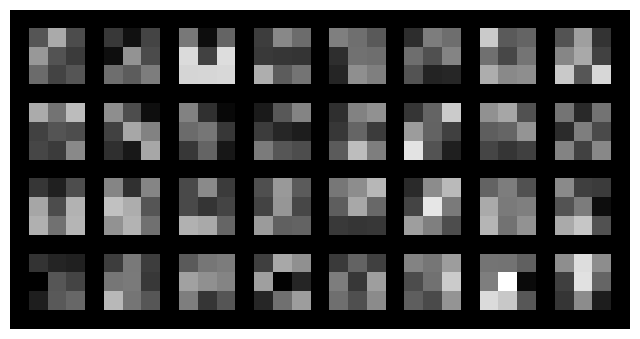

In [61]:
print_layer(model.conv5.weight.detach().clone())

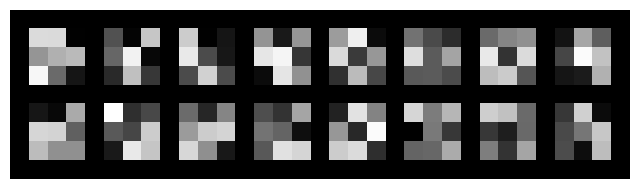

In [62]:
print_layer(model.conv4.weight.detach().clone())

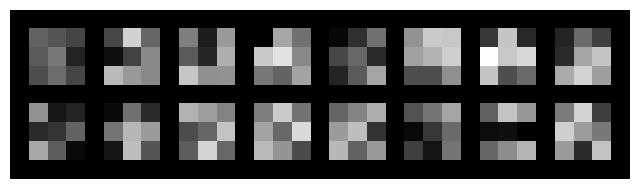

In [63]:
print_layer(model.conv3.weight.detach().clone())

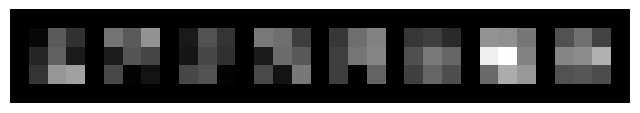

In [64]:
print_layer(model.conv2.weight.detach().clone())

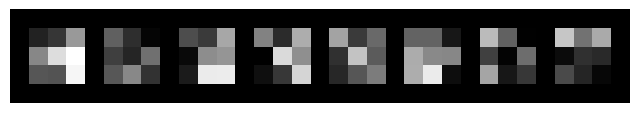

In [65]:
print_layer(model.conv1.weight.detach().clone())